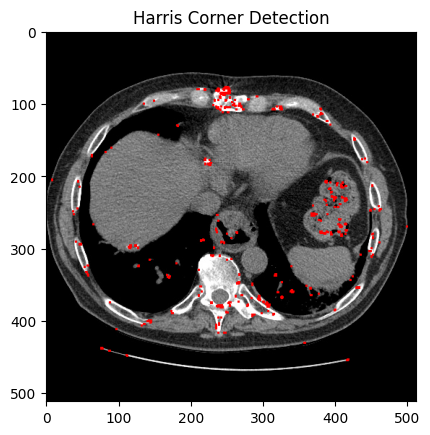

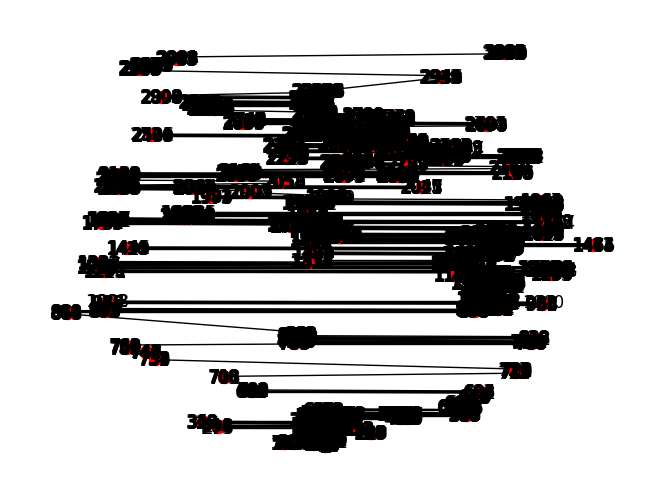

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntüyü yükle
image = cv2.imread('D:/yusuf_alaca/DARTS_MOBILEVITS/pancreatic_tumor_datasets/tumor_1.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Harris köşe algılama
gray = np.float32(gray_image)
dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Sonuçları genişletmek için dilate
dst = cv2.dilate(dst, None)

# Köşeleri işaretle
image[dst > 0.01 * dst.max()] = [0, 0, 255]

# Görüntüyü göster
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Harris Corner Detection')
plt.show()

# Seçilen köşe noktaları
corners = np.argwhere(dst > 0.01 * dst.max())

# Graf yapısı oluşturma (örnek)
# Bu adımda, köşe noktaları arasındaki ilişkiler belirlenir ve kenarlarla bağlanır
import networkx as nx

G = nx.Graph()
for i, corner in enumerate(corners):
    G.add_node(i, pos=(corner[1], corner[0]))

# Örnek kenar ekleme
for i in range(len(corners) - 1):
    G.add_edge(i, i+1)

# Grafı çiz
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_color='r', node_size=50, with_labels=True)
plt.show()


In [8]:
import cv2
import numpy as np

def harris_corner_detection(image_path, k=0.04, threshold=0.01):
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute gradients
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute derivative products
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    
    # Gaussian blur
    Sxx = cv2.GaussianBlur(Ixx, (7, 7), 1.5)
    Syy = cv2.GaussianBlur(Iyy, (7, 7), 1.5)
    Sxy = cv2.GaussianBlur(Ixy, (7, 7), 1.5)
    
    # Compute Harris response
    height, width = gray.shape
    R = np.zeros_like(gray, dtype=np.float32)
    
    for y in range(height):
        for x in range(width):
            H = np.array([[Sxx[y, x], Sxy[y, x]], 
                          [Sxy[y, x], Syy[y, x]]])
            
            R[y, x] = np.linalg.det(H) - k * (np.trace(H) ** 2)
    
    # Threshold and mark corners
    result_img = img.copy()
    corners = R > (threshold * R.max())
    result_img[corners] = [0, 0, 255]
    
    return result_img

# Example usage
try:
    result_img = harris_corner_detection('D:/yusuf_alaca/DARTS_MOBILEVITS/pancreatic_tumor_datasets/tumor_1.jpg')
    cv2.imshow('Harris Corners', result_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
except Exception as e:
    print(f"Error processing image: {e}")

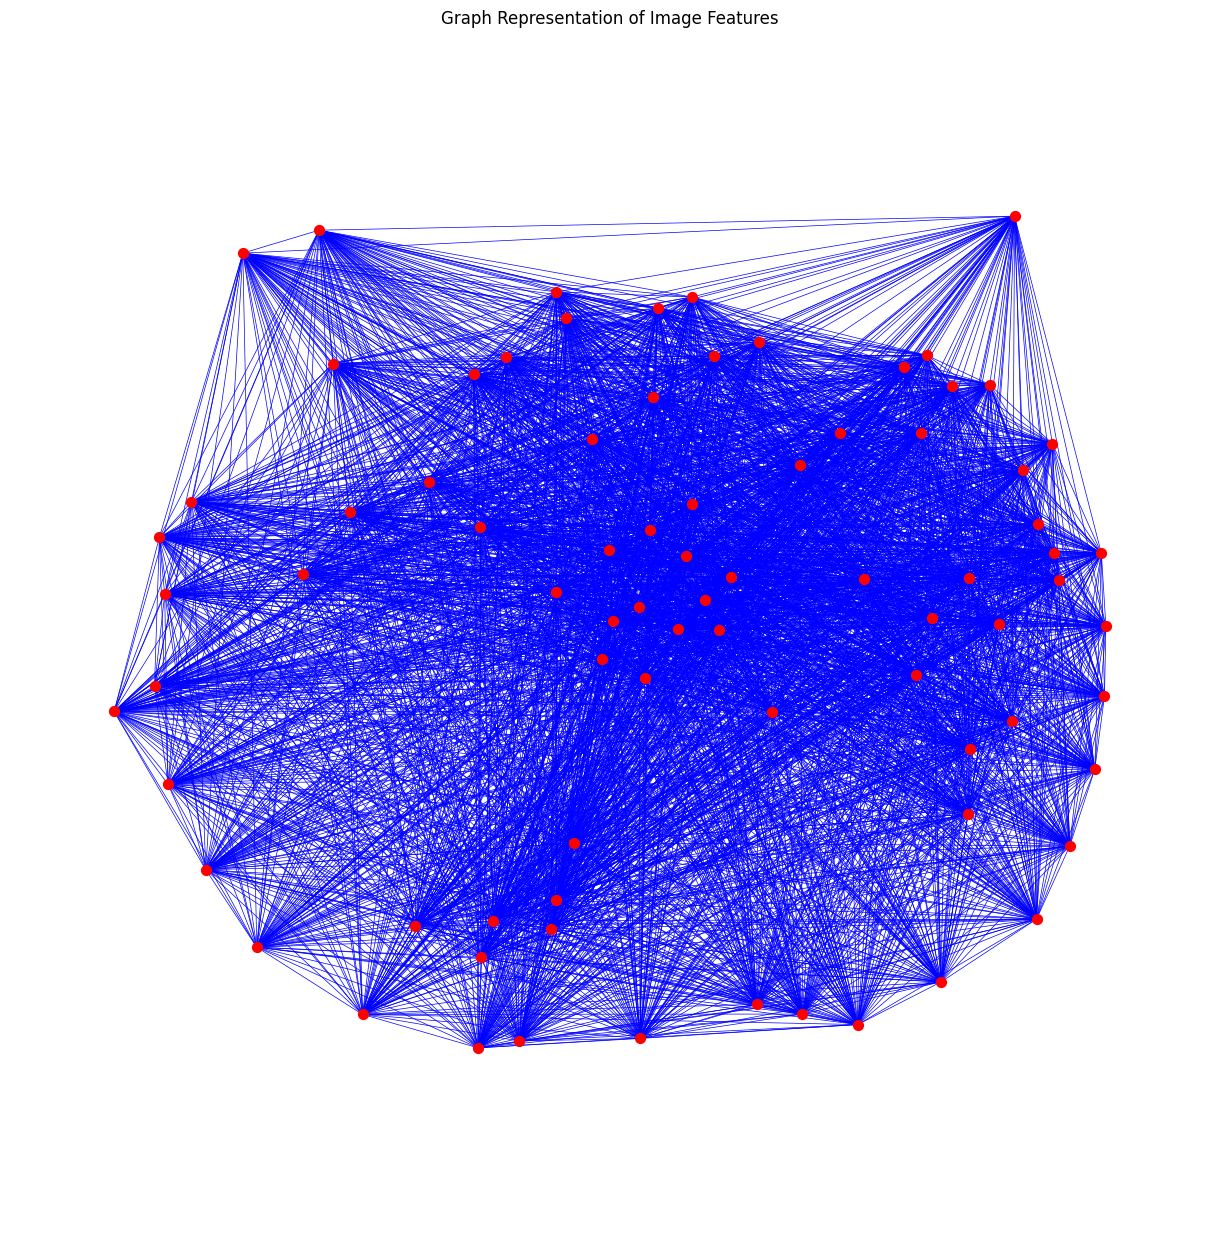

In [9]:
import numpy as np
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
import cv2

def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def extract_features(image):
    # Harris köşe algılama
    gray = np.float32(image)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    
    # Eşikleme
    ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)
    
    # Bağlantı bileşenleri analizi
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    
    return centroids

def image_to_graph(image_path):
    # Resmi yükle ve gri tonlamalıya çevir
    image = Image.open(image_path).convert('L')
    image_data = np.array(image)
    
    # Resmi 224x224 boyutuna getir
    image_data = resize_image(image_data, size=(224, 224))
    
    # Özellik çıkarma (Harris köşe algılama)
    features = extract_features(image_data)
    
    # Grafik veri yapısını oluştur
    G = nx.Graph()
    
    # Düğüm ekle
    for i, (x, y) in enumerate(features):
        G.add_node(i, pos=(x, y))
    
    # Kenar ekle (Euclidean mesafe ile komşular)
    for i, (x1, y1) in enumerate(features):
        for j, (x2, y2) in enumerate(features):
            if i != j:
                dist = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                G.add_edge(i, j, weight=dist)
    
    return G

def plot_graph(G):
    # Grafiği görselleştir
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, node_size=50, node_color='red', with_labels=False, width=0.5, edge_color='blue')
    plt.title("Graph Representation of Image Features")
    plt.axis('equal')
    plt.show()

# Örnek kullanım
image_path = 'D:/yusuf_alaca/DARTS_MOBILEVITS/pancreatic_tumor_datasets/tumor_1.jpg'  # Buraya resim dosya yolunu girin
G = image_to_graph(image_path)
plot_graph(G)
